<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S34_vacuum_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
%pip install -U -q gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import plotly.express as px
import numpy as np
import gtsam
import pandas as pd

import gtbook
import gtbook.display
from gtbook import vacuum
from gtbook.discrete import Variables
VARIABLES = Variables()

def pretty(obj):
    return gtbook.display.pretty(obj, VARIABLES)

def show(obj, **kwargs):
    return gtbook.display.show(obj, VARIABLES, **kwargs)

try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

In [3]:
# From section 3.2:
wxyz = gtsam.DiscreteBayesNet()
W1 = VARIABLES.binary("W")
X1 = VARIABLES.binary("X")
Y1 = VARIABLES.binary("Y")
Z1 = VARIABLES.binary("Z")
wxyz.add(W1, [X1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(X1, [Y1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(Y1, [Z1], "1/1 1/1")
wxyz.add(Z1, "1/1")

# From Section 3.3:
N = 3
X = VARIABLES.discrete_series("X", range(1, N+1), vacuum.rooms)
A = VARIABLES.discrete_series("A", range(1, N), vacuum.action_space)
Z = VARIABLES.discrete_series("Z", range(1, N+1), vacuum.light_levels)

# Perception with Graphical Models

> Perception for dynamic Bayes nets is equivalent to inference in hidden Markov models or HMMs.

In [4]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(3, 4, "steampunk", 1))

Bayes nets are great for *modeling*, but for infering the state of the robot over time we need better data structures. 
We first more formally define what we mean by inference, and introduce MAP and MPE inferemce.
We then define hidden Markov models, and highlight their connection with robot
localization over time. 
We then show how to efficiently perform inference by converting any Bayes net (with evidence) to a factor graph. 
We show both full posterior inference, MPE, and MAP estimation for HMMs. 


## Inference in Bayes Nets

> Inference can mean full posterior inference, maximum probable explanation, or maximum a posteriori inference.

**Inference** is the process of obtaining knowledge about a subset of
variables given the known values for another subset of variables. In
this section we will talk about how to do inference when the joint
distribution is specified using a Bayes net, but we will not take
advantage of the sparse structure of the network. Hence, the algorithms
below are completely general, for any (discrete) joint probability
distribution, as long as you can evaluate the joint.


### Full Posterior Inference

The simplest case occurs when we can *partition* the variables into two
sets: the hidden variables $\mathcal{X}$ and the observed values
$\mathcal{Z}$. Then we can simply apply Bayes’ rule, but now applied to
*sets* of variables, to obtain an expression for the posterior over the
hidden variables $\mathcal{X}$. Using the "easy" version of Bayes’ law
we obtain

$$P(\mathcal{X}|\mathcal{Z}=\mathfrak{z})\propto P(\mathcal{X}, \mathcal{Z}=\mathfrak{z}), $$

where $\mathfrak{z}$ is the set of observed values for all variables in
$\mathcal{Z}$.


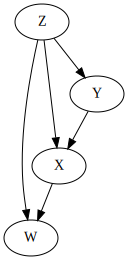

In [5]:
show(wxyz)

There is an easy algorithm to calculate the posterior distribution
above: simply enumerate all tuples $\mathcal{X}$ in a table, evaluate
$P(\mathcal{X}, \mathcal{Z}=\mathfrak{z})$ for each one, and then
normalize. As an example, let us consider the Bayes net on W, X, Y, Z above, 
and take $\mathcal{X}=(X, Y)$ and $\mathcal{Z}=(W, Z)$. 
As before, let us assume that each variable can take on 10 different outcomes, and that
$\mathfrak{z}=(2, 7)$. The resulting table for
$P(X, Y|W=2, Z=7)\propto P(W=2, X, Y, Z=7)$ is shown in the table below:

|    *x*   |    *y*   |                 *P(W=2, X=x, Y=y, Z=7)*                |
|:--------:|:--------:|:---------------------------------------------------:|
|     1    |     1    |*P(W=2\|X=1, Z=7)P(X=1\Y=1, Z=7)P(Y=1\Z=7)P(Z=7)*   |
|     1    |     2    |    *P(W=2\|X=1, Z=7)P(X=1\|Y=2, Z=7)P(Y=2\|Z=7)P(Z=7)*   |
| ... | ... |                       ...                      |
|    10    |     9    |   *P(W=2\|X=10, Z=7)P(X=10\|Y=9, Z=7)P(Y=9\|Z=7)P(Z=7)*  |
|    10    |    10    | *P(W=2\|X=10, Z=7)P(X=10\|Y=10, Z=7)P(Y=10\|Z=7)P(Z=7)* |

We normalize by calculating $\sum_{x, y} P(W=2, X=x, Y=y, Z=7)$ by summing over all these entries, and subsequently dividing all entries by the sum.

### Maximum Probably Explanation

A common inference problem associated with Bayes nets is the **most
probable explanation** or MPE for $\mathcal{X}$: given the values
$\mathfrak{z}$ for $\mathcal{Z}$, what is the most probable joint
assignment to the other variables $\mathcal{X}$? While the posterior
gives us the complete picture, the MPE is different in nature: it is a
single assignment of values to $\mathcal{X}$:

$$x^*_{MPE} = \arg \max_x P(\mathcal{X}|\mathcal{Z}=\mathfrak{z}).$$

For example, given
$\mathfrak{z}=(2, 7)$, the MPE for $\mathcal{X}$ could be $X=3$ and
$Y=6$. Note that to compute the MPE, we need not bother with
normalizing: we can simply find the maximum entry in the unnormalized
posterior values.


### Efficiency (Not!)

In both these inference problems, the simple algorithm outlined above is
*not* efficient. In the example the table is 100 entries long, and in
general the number of entries is exponential in the size of
$\mathcal{X}$. However, when inspecting the entries in the table
there are already some obvious ways to save: for example, $P(Z=7)$ is a
common factor in all entries, so clearly we should not even bother
multiplying it in. Below we will discuss methods to fully
exploit the structure of the Bayes net to perform efficient inference.

If we had an efficient way to do inference, an MPE estimate would be a
great way to estimate the trajectory of a robot over time. For example, 
using the "robot" dynamic Bayes net example from the last section, let us
assume that we are given the value of all observations $O$ and actions
$A$. Then the MPE would simply be a trajectory of robot states through
the grid. This is an example of robot localization over time, and is a
key capability of a mobile robot. However, it will have to wait until we
can do efficient inference.


### Maximum a Posteriori estimation

Finally, another well known inference problem is the **maximum a
posteriori** or MAP estimate: given the values of some variables
$\mathcal{Z}$, what is the most probable joint assignment to a *subset*
$\mathcal{X}$ of the other variables? In this case the variables are
partitioned into three sets: the variables of interest $\mathcal{X}$, 
the nuisance variables $\mathcal{Y}$, and the observed variables
$\mathcal{Z}$:

$$
P(\mathcal{X}|\mathcal{Z}=\mathfrak{z})=\sum_{\mathfrak{y}}P(\mathcal{X}, \mathcal{Y}=\mathfrak{y}|\mathcal{Z}=\mathfrak{z})\propto\sum_{\mathfrak{y}}P(\mathcal{X}, \mathcal{Y}=\mathfrak{y}, \mathcal{Z}=\mathfrak{z}).
$$

Finding a MAP estimate is more expensive than finding the MPE, as in
addition to enumerating all possible combinations of $\mathcal{X}$ and
$\mathcal{Y}$ values, we now need to calculate
a possibly large number of sums, each exponential in the size of
$\mathcal{Y}$. In addition, the *number* of sums is
exponential in the size of $\mathcal{X}$. Below we will see that
while we can still exploit the Bayes net structure, MAP estimates are
fundamentally more expensive even in that case.


### Exercises

1.  Show that in the example above, if we condition on known values for $\mathcal{Z}=(X,Z)$, the
    posterior $P(W,Z|X,Y)$ factors, and as a consequence we only have to
    enumerate two tables of length 10, instead of a large table of
    size 100.

2.  Calculate the size of the table needed to enumerate the posterior
    over the states $S$ the robot dynamic Bayes net from the previous section,
    given the value of all observations $Z$ and actions $A$.

3.  Show that if we are given the states, inferring the actions is
    actually quite efficient, even with the brute force enumeration.
    Hint: this is similar to the first exercise above.


## Hidden Markov Models

> HMMs are a general framework for perception over time.

Here we will generalize from robots to arbitrary state and observation spaces. In the previous section we discussed dynamic Bayes networks to model how a robot state evolves over time by taking actions, and how measurements result in a particular state. In this section we will ask *how we can recover the state of the robot given only the observations*, i.e. without knowing the states: the state is "hidden". Here we will consider a general framework to answer this question.

A **hidden Markov model** or HMM is a dynamic Bayes net that has two
types of variables: states $\mathcal{X}$ and measurements $\mathcal{Z}$.
The states $\mathcal{X}$ are connected sequentially and satisfy the what
is called the **Markov property**: the probability of a state $X_{t}$ is
only dependent on the value of the previous state $X_{t-1}$. As we saw before, we call a sequence of random variables with this property a **Markov chain.** 
In addition, in an HMM we refer to the states $\mathcal{X}$ as *hidden*
states, as typically we cannot directly observe their values. Instead, 
they are indirectly observed through the measurements $\mathcal{Z}$, 
where we have one measurement per hidden state. When these two
properties are satisfied, we call this probabilistic model a hidden
Markov model.


<figure> 
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/hmm-v2.png?raw=1" id="fig:unrolledHMM" style="width:14cm" alt="">
<figcaption>An HMM, unrolled over three time-steps, represented by a Bayes net.</figcaption>
</figure>

Figure
<a href="#fig:unrolledHMM" data-reference-type="ref" data-reference="fig:unrolledHMM">1</a>
shows an example of an HMM for three time steps, i.e.., 
$\mathcal{X}=\{X_1, X_2, X_3\}$ and
$\mathcal{Z}=\{Z_1, Z_2, Z_3\}$. As we discussed, in a Bayes net
each node is associated with a conditional distribution: the Markov
chain has the prior $P(X_1)$ and transition probabilities
$P(X_2|X_1)$ and $P(X_3|X_2)$, whereas the measurements $Z_{t}$
depend only on the state $X_{t}$, modeled by measurement models
$P(Z_{t}|X_{t})$. In other words, the Bayes net encodes the following
joint distribution $P(\mathcal{X}, \mathcal{Z})$:

$$P(\mathcal{X}, \mathcal{Z})=P(X_1)P(Z_1|X_1)P(X_2|X_1)P(Z_2|X_2)P(X_3|X_2)P(Z_3|X_3)$$

Note that we can also write this more succinctly as

$$P(\mathcal{X}, \mathcal{Z})=P(\mathcal{Z}|\mathcal{X})P(\mathcal{X})$$

where

$$P(\mathcal{X})=P(X_1, X_2, X_3)=P(X_1)P(X_2|X_1)P(X_3|X_2)$$

is the prior over state *trajectories*.


### Example: Robot HMM

Let us re-create the dynamic Bayes net from the previous section here, with 3 time steps:


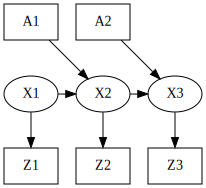

In [8]:
dbn = gtsam.DiscreteBayesNet()
for k in range(1, N+1):
    dbn.add(Z[k], [X[k]], vacuum.sensor_spec)
for k in reversed(range(1, N)):
    dbn.add(X[k+1], [X[k], A[k]], vacuum.action_spec)
dbn.add(X[1], "1/1/1/1/1")
show(dbn, hints={"A": 2, "X": 1, "Z": 0}, boxes={A[k][0] for k in range(1, N)}.union({Z[k][0] for k in range(1, N+1)}))

## Naive Inference in HMMs

> Inference is easy to implement naively, but hopelessly inefficient.

In inference, we might want to infer the maximum probable explanation
(MPE) for the states $\mathcal{X}$ given values
$\mathfrak{z}=\{z_1, z_2, z_3\}$ for $\mathcal{Z}$. As we saw
before, one way to perform inference is to apply Bayes’ rule to obtain an expression for the *posterior* probability distribution over
the state trajectory $\mathcal{X}$, given the measurements
$\mathcal{Z}=\mathfrak{z}$:

$$\begin{aligned}
P(\mathcal{X}|\mathcal{Z}) & \propto P(\mathcal{Z}=\mathfrak{z}|\mathcal{X})P(\mathcal{X}) \\
& =L(\mathcal{X}; \mathcal{Z}=\mathfrak{z})P(\mathcal{X})\end{aligned}
$$

where $P(\mathcal{X})$ is the trajectory prior
and the **likelihood** $L(\mathcal{X}; \mathcal{Z}=\mathfrak{z})$ of
$\mathcal{X}$ given $\mathcal{Z}=\mathfrak{z}$ is defined as before as a function of $\mathcal{X}$: 

$$
\begin{aligned}
L(\mathcal{X}; \mathcal{Z}=\mathfrak{z}) & \doteq P(\mathcal{Z}=\mathfrak{z}|\mathcal{X})\\
& =P(z_1|X_1)P(z_2|X_2)P(z_3|X_3)\\
& =L(X_1; Z_1)L(X_2; Z_2)L(X_3; Z_3)\end{aligned}
$$

Hence, a naive implementation for finding the **most probable
explanation** (MPE) for $\mathcal{X}$ would tabulate all possible
trajectories $\mathcal{X}$ and calculate the posterior $P(\mathcal{X}|\mathcal{Z})$ for each one. 
Unfortunately the number of entries in this giant table is
*exponential* in the number of states. Not only is this computationally
prohibitive for long trajectories, but intuitively it is clear that for
many of these trajectories we are computing the same values over and
over again. In fact, there are three different approaches to improve on
this:

1.  Branch & bound

2.  Dynamic programming

3.  Inference using factor graphs

Branch and bound is a powerful technique but will not generalize to
continuous variables, like the other two approaches will. And, we will
see that dynamic programming, which underlies the classical inference
algorithms in the HMM literature, is just a special case of the last
approach. Hence, here we will dive in and immediately go for the most
general approach: inference in factor graphs.


## Factor Graphs

> Factor graphs are *the* correct representation in which do inference.

We first introduce the notion of factors. 
Again referring to the example from Figure
<a href="#fig:unrolledHMM" data-reference-type="ref" data-reference="fig:unrolledHMM">1</a>, 
let us consider the posterior.
Since the measurements $\mathcal{Z}$ are *known*, the posterior is
proportional to the product of six **factors**, three of which derive
from the the Markov chain, and three are likelihood factors as defined
before:

$$
P(\mathcal{X}|\mathcal{Z})\propto P(X_1)L(X_1; z_1)P(X_2|X_1)L(X_2; z_2)P(X_3|X_2)L(X_3; z_3)
$$

Some of these factors are unary factors, and some are binary factors. 
In particular, above some of the factors depend on just one hidden variable, 
for example $L(X_2; z_2)$, whereas others depend on two variables, e.g., the
transition model $P(X_3|X_2)$. 
Measurements are not counted here, 
because once we are *given* the measurements $\mathcal{Z}$, they merely
function as known parameters in the likelihoods $L(X_{t}; z_{t})$, which
are seen as functions of *just* the state $X_{t}$.


<figure>
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/fg-v2.png?raw=1" id="fig: HMM-FG" style="width:60.0%" alt="">
<figcaption>An HMM with observed measurements, unrolled over time, represented as a factor graph.</figcaption>
</figure>

This motivates a different graphical model, a **factor graph**, in which
we only represent the *hidden* variables $X_1$, $X_2$, and $X_3$, 
connected to factors that encode probabilistic information on them. For
our example with three hidden states, the corresponding factor graph is
shown in Figure
<a href="#fig: HMM-FG" data-reference-type="ref" data-reference="fig: HMM-FG">2</a> above.
It should be clear from the figure that the connectivity of a factor
graph encodes, for each factor $\phi_{i}$, which subset of variables
$\mathcal{X}_{i}$ it depends on. We write:

$$
\phi(\mathcal{X})=\phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2)\phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
$$

where the factors above are defined to correspond one-to-one to the six factors in the posterior, 
e.g., 

$$\phi_6(X_3)\doteq L(X_3; z_3).$$

All measurements are associated with unary factors, whereas the Markov chain is
associated mostly with binary factors, with the exception of the unary
factor $\phi_1(X_1)$. Note that in defining the factors we can omit
any normalization factors, which in many cases results in computational
savings.


Formally a factor graph is a bipartite graph
$F=(\mathcal{U}, \mathcal{V}, \mathcal{E})$ with two types of nodes:
**factors** $\phi_{i}\in\mathcal{U}$ and **variables**
*$X_{j}\in\mathcal{V}$.* Edges $e_{ij}\in\mathcal{E}$ are always between
factor nodes and variables nodes. The set of random variable nodes
adjacent to a factor $\phi_{i}$ is written as $\mathcal{X}_{i}$. With
these definitions, a factor graph $F$ defines the factorization of a
global function $\phi(\mathcal{X})$ as

$$\phi(\mathcal{X})=\prod_{i}\phi_{i}(\mathcal{X}_{i}).$$

In other words, the independence relationships are encoded by the edges
$e_{ij}$ of the factor graph, with each factor $\phi_{i}$ a function of
*only* the variables $\mathcal{X}_{i}$ in its adjacency set. As example, 
for the factor graph in Figure
<a href="#fig: HMM-FG" data-reference-type="ref" data-reference="fig: HMM-FG">2</a>
we have: 

$$
\begin{aligned}
\mathcal{X}_1 & =\{X_1\}\\
\mathcal{X}_2 & =\{X_1\}\\
\mathcal{X}_3 & =\{X_1, X_2\}\\
\mathcal{X}_4 & =\{X_2\}\\
\mathcal{X}_5 & =\{X_2, X_3\}\\
\mathcal{X}_6 & =\{X_3\}\end{aligned}
$$

## Converting Bayes Nets into Factor Graphs.

> It is trivial to convert Bayes nets with given variables into factor graphs.

<figure>
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/hmm-v2.png?raw=1" id="fig:conversion" style="width:12cm" alt="">
<figcaption>Bayes net representation of an HMM.</figcaption>
</figure>

<figure>
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/fg-v2.png?raw=1" id="fig:conversion" style="width:14cm" alt="">
<figcaption>Conversion of HMM above to a factor graph, where measurements are known.</figcaption>
</figure>

Every Bayes net can be trivially converted to a factor graph, as shown above.
Recall that every node in a Bayes net denotes a conditional density on the
corresponding variable and its parent nodes. Hence, the conversion is
quite simple: every Bayes net node splits in *both* a variable node and
a factor node in the corresponding factor graph. The factor is connected
to the variable node, as well as the variable nodes corresponding to the
parent nodes in the Bayes net. If some nodes in the Bayes net are
evidence nodes, i.e., they are given as known variables, we omit the
corresponding variable nodes: the known variable simply becomes a fixed
parameter in the corresponding factor.

### Exercise

1.  Convert the dynamic Bayes net from the previous section into a factor graph, assuming *no* known variables.

1.  Finally, do the same again, but now assume the states are given. Reflect on the remarkable phenomenon that happens.


### Factor Graphs in GTSAM

Let us create the factor graph directly using GTSAM. Before we do, however, we need to instantiate the given actions and measurements, both of which are assumed known:


In [37]:
actions = VARIABLES.assignment({A[1]: 'R', A[2]: 'U'})
measurements = ['dark', 'medium', 'light']

Now we create the factorgraph, first adding the prior $\phi(X_1)=P(X_1)$ on $X_1$, then the binary factors $\phi(X_k, X_{k+1}) = P(X_{k+1}|X_k, A_k=a_k)$, and then the measurements likelihood factors $\phi(X_k; Z_k=z_k) \propto P(Z_k=z_k|X_k)$:


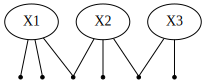

In [38]:
graph = gtsam.DiscreteFactorGraph()
graph.add(X[1], "1 1 1 1 1")  # \phi(X_1) = P(X_1)
for k in range(1, N):
    conditional = gtsam.DiscreteConditional(X[k + 1], [X[k], A[k]], vacuum.action_spec)
    conditional_a_k = conditional.choose(actions)  # \phi(X,X+) = P(X+|X,A=a)
    graph.push_back(conditional_a_k)
for i, measurement in enumerate(measurements):
    k = i + 1
    conditional = gtsam.DiscreteConditional(Z[k], [X[k]], vacuum.sensor_spec)
    z_k = vacuum.light_levels.index(measurement)
    factor = conditional.likelihood(z_k)  # \phi(X) = P(Z=z|X)
    graph.push_back(factor)
show(graph)

Note that discrete distributions and conditionals, like $P(X_1)$ above, are perfectly fine factors, and in fact *derive* from the factor type in GTSAM. This is what allows us to add them directly the graph as is. Note that in a real implementation we might not take the detour to first construct the conditionals as above: we did so because they were conveniently available here, but typically we would construct factors directly.

## Computing with Factor Graphs

> We can evaluate, optimize, and sample from factor graphs.

Once we convert a Bayes net with evidence into a factor graph where the
evidence is all implicit in the factors, we can support a number of
different computations. First, given any factor graph defining an
unnormalized density $\phi(X)$, we can easily **evaluate** it for any
given value, by simply evaluating every factor and multiplying the
results. The factor graph represents the unnormalized posterior, i.e., 
$\phi(\mathcal{X})\propto P(\mathcal{X}|\mathcal{Z})$. 

Evaluation opens up the way to **optimization**, e.g., finding the most probable
explanation or MPE, as we will do below. In the case of discrete
variables, graph search methods can be applied, but we will use a
different approach.

While local or global maxima of the posterior are often of most
interest, **sampling** from a probability density can be used to
visualize, explore, and compute statistics and expected values
associated with the posterior. However, the ancestral sampling method we
discussed earlier only applies to directed acyclic graphs. There are
however more general sampling algorithms that can be used for factor
graphs, more specifically Markov chain Monte Carlo (MCMC) methods. One
such method is Gibbs sampling, which proceeds by sampling one variable
at a time from its conditional density given all other variables it is
connected to via factors. This assumes that this conditional density can
be easily obtained, which is in fact true for discrete variables.

Below we use factor graphs as the organizing principle for probabilistic
inference. In later chapters we will expand their use to continuous
variables, and will see that factor graphs aptly describe the
independence assumptions and sparse nature of the large nonlinear
least-squares problems arising in robotics. But their usefulness extends
far beyond that: they are at the core of the sparse linear solvers we
use as building blocks, they clearly show the nature of filtering and
incremental inference, and lead naturally to distributed and/or parallel
versions of robotics.

### Naive MPE with GTSAM

Because our factor graph is so small, it does not hurt to show off how easy it is to implement the naive algorithm. We just loop over all possible state trajectories, and keep track of the one with the highest value:

In [39]:
mpe_value = 0
mpe_trajectory = None
for x1 in vacuum.rooms:
    for x2 in vacuum.rooms:
        for x3 in vacuum.rooms:
            trajectory = VARIABLES.assignment({X[1]: x1, X[2]: x2, X[3]: x3})
            value = graph(trajectory)
            if value > mpe_value:
                mpe_value = value
                mpe_trajectory = trajectory
print(f"found MPE solution with value {mpe_value:.4f}:")
pretty(mpe_trajectory)

found MPE solution with value 0.3277:


Variable,value
X1,Hallway
X2,Dining Room
X3,Kitchen


Remember that this MPE is *for a given action and measurement sequence*. All those fixed values are implicit in the factors that we have added to the factor graph in `graph` above.

## The Max-Product Algorithm for HMMs

> Max-product on HMMs, also known as the Viterbi algorithm, is a dynamic-programming algorithm for finding the MPE.

In this section we discuss an algorithm that is much faster than the naive algorithm to find the MPE.
Given a factor graph, the **max-product algorithm** is an $O(n)$ algorithm
to find the maximum probable explanation or MPE.
We will use the example from Figure
<a href="#fig: HMM-FG" data-reference-type="ref" data-reference="fig: HMM-FG">2</a>
to give the intuition. To find the MPE for $\mathcal{X}$ we need to
*maximize* the product

$$\phi(X_1, X_2, X_3)=\prod\phi_{i}(\mathcal{X}_{i})$$

i.e., the **value** of the factor graph. 

Because the value of the factor graph is a product of factor values, we can compute its maximum recursively, dynamic programming style. We start by first looking at ll factors connected to $X_1$:

$$
\begin{align*}
\max_\mathcal{X} \prod\phi_{i}(\mathcal{X}_{i})
&= \max_{X_1, X_2, X_3} ~~~\phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2) &\phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
\\ &= \max_{X_2, X_3} ~~~\{ \max_{X_1} \phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2) \} &\phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
\\ &= \max_{X_2, X_3} ~~~\tau(X_2) &\phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
\end{align*}
$$

Above $\tau(X_2)\doteq \max_{X_1} \phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2)$ records the maximum value resulting from *only* maximizing $X_1$, but this depends on the value of $X_2$. After we recursively find the optimal values for $X_2$ and $X_3$, we can recover $X_1$ by

$$
g_1(X_2) = \arg \max_{X_1} \phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2)
$$

where the *lookup table* can be created at the same time that we compute $\tau(X_2)$.

The above shows the general principle for max-product by concentrating on $X_1$, but we must do the same computation for all other variables as well. 
Below we use the factor graph to illustrate how the max-product algorithm
proceeds one variable at a time, using "Bayes-net-style" directed edges to represent the lookup tables $g_k(X_{k+1})$, and factors to represent the $\tau(.)$ functions, as indeed they *are* factors. Because at every step, one variable is *eliminated* from the maximization, the max-product algorithm is in fact an instance of the **elimination algorithm**, which we will see pop up in many different guises.

We proceed from left to right, i.e. we start with state $X_1$ and proceed until we
processed all states. We will tackle the three steps one by one in ths subsections below:

### Eliminating $X_1$

<figure>
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/max-product-1.png?raw=1" style="width:60.0%" alt="Eliminating X1">
</figure>

We start by considering the first state $X_1$, and we form a **product
factor** $\phi(X_1, X_2)$ that collects *only* the factors connected
to $X_1$:

$$
\phi(X_1, X_2)=\phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2).
$$

When we use a factor in a product, we *remove* it from the original
factor graph. Note that because one of those factors, the state
transition model $\phi_3(X_1, X_2)\doteq P(X_2|X_1)$, is also
connected to the second state $X_2$, the product factor is a function
of *both* $X_1$ and $X_2$, i.e., it is a binary factor.

The key observation in the max-product algorithm is that we can now
*eliminate* $X_1$ from the problem, by looking at all possible values
$x_2$ of $X_2$, and creating a lookup table $g_1$ for the best
possible value of $X_1$:

$$
g_1(X_2)=\arg \max_{x_1}\phi(x_1, X_2).
$$
 
The size of this lookup table is equal to the number of possible outcomes for $X_2$: 
in our vacuum-world example this is 5, as there are 5 rooms.

We also record the value of the product factor for that maximum, so we
can use it down the line for taking into account the consequence of each
choice:

$$
\tau(X_2)=\max_{x_1}\phi(x_1, X_2).
$$

In practice both steps can be implemented in a single "eliminate" function.
We then put this new factor $\tau(X_2)$ back into the graph, essentially
summarizing the result of eliminating $X_1$ from the problem entirely, 
obtaining the **reduced graph**

$$
\Phi_{2:3}=\tau(X_2)\phi_4(X_2)\phi_5(X_2, X_3)\phi_6(X_3).
$$

Let us reflect on what happened above, because it is significant: we
eliminated $X_1$ from consideration, and obtained a reduced problem
that only depends on the remaining states $X_2$ and $X_3$. You can
intuitively see that this algorithm will terminate after $n$ steps, and
in fact you could prove it by induction. In addition, the lookup table
$g_1$ gives us a way that, once we know what the optimal value for
$X_2$ is, we can just read off the optimal value for $X_1$. This is
what we will do, in *reverse* elimination order, after the algorithm
terminates.

### Eliminating $X_2$

<figure>
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/max-product-2.png?raw=1" style="width:50.0%" alt="Eliminating X2">
</figure>

We now perform exactly the same steps for the state $X_2$. In this
case, the product factor $\phi(X_2, X_3)$ has only factors connected
to $X_2$, 

$$
\phi(X_2, X_3)=\tau(X_2)\phi_4(X_2)\phi_5(X_2, X_3), 
$$

which now includes the factor $\tau(X_2)$ from the previous step. 
Note that since we started from the reduced graph, 
the product factor is guaranteed to not depend on the first state
$X_1$: that was eliminated! In fact, we can now in turn eliminate
$X_2$ from the problem, by looking at all possible values $x_3$ of
$X_3$, and creating a lookup table $g_2$ for the best possible value
of $X_2$, given $X_3$, 

$$
g_2(X_3)=\arg \max_{x_2}\phi(x_2, X_3), 
$$

and as above we also
record the value of the product factor for that maximum in a new factor
$\tau(X_3)$:

$$
\tau(X_3)=\max_{x_2}\phi(x_2, X_3).
$$

We then put this new factor $\tau(X_3)$ back into the graph, which is now reduced even more: 

$$
\Phi_{3:3}=\tau(X_3)\phi_6(X_3).
$$

### Eliminating $X_3$

<figure>
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/max-product-3.png?raw=1" style="width:50.0%" alt="Eliminating X3">
</figure>

Finally, we eliminate $X_3$, where the product factor is now the
entire remaining graph and only depends on $X_3$, as all other states
have already been eliminated:

$$
\phi(X_3)=\tau(X_3)\phi_6(X_3).
$$

We again obtain a lookup table,

$$
g_3(\emptyset)=\arg \max_{x_3}\phi(x_3), 
$$

and a new factor:

$$
\tau(\emptyset)=\max_{x_3}\phi(x_3).
$$

Note however that now the value does not depend on any arguments! 
This is indicated by making the argument list equal to the empty set $\emptyset$.
Indeed, $g_3$ just tells us what the best value for $X_3$ is, and $\tau$
tells us the corresponding value. Because it incorporates the factors
from the previous elimination steps, this will in fact be exactly the
MPE solution, and the recursion ends!

### Back-substitution

Once we know the value for $X_3$, we can simply plug it into the
lookup table $g_2(X_3)$ to get the value for $X_2$, which we can
then plug into the lookup table $g_1$ to get the value for $X_1$, 
and we recover the MPE in one single backward pass.


### Summary: Max-Product

The complete HMM max-product algorithm for any value of $n$ is given below, 
where we used the shorthand notation $\Phi_{j:n}\doteq\phi(X_{j}, \ldots, X_{n})$ 
to denote a reduced factor graph.
The algorithm proceeds by eliminating one hidden state $X_{j}$ at
a time, starting with the complete HMM factor graph $\Phi_{1:n}$. As we
eliminate each variable $X_{j}$, the function produces a single lookup
table $g_{j}(X_{j+1})$, as well as a reduced factor graph $\Phi_{j+1:n}$
on the remaining variables. After all variables have been eliminated, 
the algorithm returns a chain of lookup tables that can be used to
recover the MPE in reverse elimination order.

---
`MaxProductHMM` ($\Phi_{1:n}$):
* for $j=1...n$:
  + $g_{j}(X_{j+1}), \Phi_{j+1:n}\gets \text{CreateLookupTable}(\Phi_{j:n}, X_{j})$
  + return $g_1(X_2)g_2(X_3)\ldots g_{n}(\emptyset)$

`CreateLookupTable` ($\Phi_{j:n}, X_{j}$):
* Remove all factors $\phi_{i}(\mathcal{X}_{i})$ that contain $X_{j}$ 
* Form the product factor $\phi(X_{j}, X_{j+1})\gets\prod_{i}\phi_{i}(\mathcal{X}_{i})$
* Eliminate $X_j$: $g_{j}(X_{j+1}), \tau(X_{j+1})\gets\phi(X_{j}, X_{j+1})$
* Add new factor $\tau(X_{j+1})$ back into the graph $\Phi_{j+1:n}$
* return the lookup table $g_{j}(X_{j+1})$ and reduced graph $\Phi_{j+1:n}$
---

In the HMM literature, the max-product algorithm is known as the *Viterbi* algorithm. However, we will see that max-product (and sum-product below) can be applied in more general settings than the linear chains one finds in HMMs.

#### Exercise

In the above, the lookup table $g_{j}(X_{j+1})$ resulting from eliminating $X_j$ is a function of only $X_{j+1}$, because an HMM is a *chain* of variables. Think about the more general case: what would $g$ be a function of, in that case?

### Complexity

The complexity of max-product is *linear* in the number of nodes, which is a nice improvement over exponential. The complexity of every elimination step is quadratic in the number of states, because we have to form the product factors and then maximize over them.

### Max-product in GTSAM

GTSAM's bread and butter is factor graphs, and finding the MPE is easy:


In [40]:
mpe = graph.optimize()
pretty(mpe)

Variable,value
X1,Hallway
X2,Dining Room
X3,Kitchen


## The Sum-Product Algorithm for HMMs

> Sum-product on HMMs, also known as the Forward-Backward algorithm algorithm, is a dynamic-programming algorithm for doing full posterior inference.

The sum-product algorithm for HMMs is a slight tweak on the max-product
algorithm that instead produces a Bayes net that calculates the
posterior probability $P(\mathcal{X}|\mathcal{Z})$. Whereas the
max-product produces a DAG of lookup tables, the sum-product produces a
DAG of conditionals, i.e., a Bayes net. This is particularly interesting
if one is not content with a maximum probable explanation or MPE, but
instead wants the **full Bayesian probability distribution** of which
assignments to the states are more probable than others. The fact that
we recover this distribution in the form of a Bayes net again is
satisfying, because as we saw that is an economical representation of a
probability distribution.

One might wonder about the wisdom of all this: we started with a Bayes
net, converted to a factor graph, and now end up with a Bayes net again?
There are two important differences: the first Bayes net
represents the joint distribution $P(\mathcal{X}, \mathcal{Z})$ and is
very useful for modeling. However, the second Bayes represents the
posterior $P(\mathcal{X}|\mathcal{Z})$, and only has nodes for the
random variables in $\mathcal{X}$, hence it is much smaller. Finally, in
many practical cases we do not even bother with the modeling step, but
construct the factor graph directly from the measurements.


Again, the key is that we can compute the posterior recursively from the product of factors, in dynamic programming style:

$$
\begin{align*}
P(\mathcal{X}|\mathcal{Z}) &\propto \prod\phi_{i}(\mathcal{X}_{i})
\\&\propto \phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2) \phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
\\&\propto \{\phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2)\} ~~ \phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
\\ &\propto \{P(X_1|X_2, \mathcal{Z}) \tau(X_2)\} ~~ \phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
\\ &= P(X_1|X_2, \mathcal{Z}) ~~ P(X_2, X_3|\mathcal{Z})
\end{align*}
$$
where the last equality invoked recursion to calculate the posterior $P(X_2, X_3|\mathcal{Z})$ on the remaining variables from the remain factors. Below we assume the dependence on the given measurements $\mathcal{Z}$ (and actions, if appropriate) as implied, and drop $\mathcal{Z}$ from the equations.

In contrast to max-product, we now define the factor $\tau$ obtained by *summing* over the variable that is being eliminated

$$
\tau(X_2)\doteq \sum_{X_1} \phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2)
$$

and, from the definition of conditional probability:

$$
P(X_1|X_2) = \frac{\phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2)}{\tau(X_2)}.
$$

Hence, the only tweak necessary to the max-product is to replace the maximization and $\arg \max$ in the elimination step with the chain rule. 
Indeed, we factor each product
factor $\phi(X_{j}, X_{j+1})$ into a conditional $P(X_{j}|X_{j+1})$ and
an (unnormalized) marginal $\tau(X_{j+1})$:

$$
P(X_{j}|X_{j+1})\tau(X_{j+1})\gets\phi(X_{j}, X_{j+1})
$$

The algorithm is called the **sum-product algorithm** because the
marginal is obtained by summing over all values of the state $X_{j}$:

$$
\tau(X_{j+1})=\sum_{x_{j}}\phi(x_{j}, X_{j+1})
$$

We do not bother normalizing this into a proper distribution, as these
marginals are just intermediate steps in the algorithm. However, when
computing the conditional, we do normalize, and is it so happens the
normalization constant is simply equal to $1/\tau(X_{j+1})$:

$$
P(X_{j}|X_{j+1})=\frac{\phi(X_{j}, X_{j+1})}{\tau(X_{j+1})}
$$

The entire algorithm is is listed below:

---
`SumProductHMM` ($\Phi_{1:n}$):
* for $j=1...n$:
    - $P(X_{j}|X_{j+1}),\Phi_{j+1:n}\gets \text{ApplyChainRule}(\Phi_{j:n},X_{j})$
    - return Bayes net $P(X_1|X_2)P(X_2|X_3)\ldots P(X_{n})$

`ApplyChainRule` ($\Phi_{j:n}, X_{j}$):
* Remove all factors $\phi_{i}(\mathcal{X}_{i})$ that contain $X_{j}$ 
* Create product factor $\phi(X_{j}, X_{j+1})\gets\prod_{i}\phi_{i}(\mathcal{X}_{i})$
* Factorize the product $P(X_{j}|X_{j+1})\tau(X_{j+1})\gets\phi(X_{j}, X_{j+1})$
* Add the new factor $\tau(X_{j+1})$ back into the graph $\Phi_{j+1:n}$
* return the conditional $P(X_{j}|X_{j+1})$ and reduced graph $\Phi_{j+1:n}$
---

Note that after we recover the Bayes net the algorithm terminates: there
is no back-substitution step. However, one might consider ancestral
sampling as a type of back-substitution: the reverse elimination order
is always a topological sort of the resulting Bayes net! Hence, after
the sum-product algorithm, we can sample as many realizations from the
posterior as we want: rather than just one MPE, we now have thousands of
plausible explanations, and ancestral sampling will yield them in
exactly the correct frequencies.


### Sidebar

When we can produce samples $\mathcal{X}^{(s)}$ from a posterior
$P(\mathcal{X}|\mathcal{Z})$, we can calculate empirical means of any
real-valued function $f(\mathcal{X})$ as follows:

$$
E_{P(\mathcal{X}|\mathcal{Z})}[f(x)]\approx\sum f(\mathcal{X}^{(s)})
$$

For example, we can calculate the posterior mean of how far the robot
traveled, either in Euclidean or Manhattan distance. These estimators
will have less variability than just calculating the distance for the
MPE, as they average over the entire probability distribution.


### Sum-Product in GTSAM

In GTSAM, calling `sumProduct` yields a Bayes net, which encodes the full posterior:

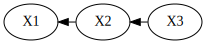

In [41]:
posterior = graph.sumProduct()
show(posterior, hints={"X": 1})

One of the things we can do with this *exact* posterior is sample from it, which is one possible state history conditioned on the available sensor measurements *and* the known action sequence:

In [42]:
sample = posterior.sample()
pretty(sample)

Variable,value
X1,Hallway
X2,Dining Room
X3,Kitchen


We can go even further: the code below samples 1000 alternate state histories, parallel universes of what *could* have happened: 

In [43]:
counts = np.zeros((3, 5))
num_samples = 1000
for i in range(num_samples):
    sample = posterior.sample()
    for k in range(1,3+1):
        key = X[k][0]
        room_index = sample[key]
        counts[k-1][room_index] += 1 # base 0!

Could we summarize these 1000 alternate histories some way other than printing all of them out? One idea is to summarize, for every time step, what the probability is to be in a particular room. It turns out we can do this with a one-liner, because we kept track of counts in the code above:

In [44]:
pd.DataFrame(data=100*counts/num_samples, 
             index=range(1, N+1), columns=vacuum.rooms)

,Living Room,Kitchen,Office,Hallway,Dining Room
1,1.7,1.4,2.8,83.9,10.2
2,0.7,2.4,0.6,5.4,90.9
3,5.8,91.1,0.6,0.3,2.2


These approximate marginals say how probable it is that the robot was in a particular room at a particular time step. This is much richer information that what is available in the MPE, which is just a point estimate for the trajectory. In the next section we will see how to go even further, and compute approximate costs associated with taking actions.

### Exercise

Execute the cell above multiple times and observe you *do* get different realizations (almost) every time, but that the approximate marginals stay roughly the same.

## GTSAM 101

> The GTSAM concepts used in this section, explained.

We created, for the first time, an instance of the `gtsam.DiscreteFactorGraph` class. The constructor is trivial - takes no arguments.
To add factors, we can use the following methods:

 1. `add(self, j: Tuple[int, int], spec: str) -> None`

 2. `add(self, j: Tuple[int, int], spec: List[float]) -> None`

 3. `add(self, keys: List[Tuple[int, int]], spec: str) -> None`

These are very similar to the `gtsam.DiscreteBayesNet` methods, but in factor graphs distinction between frontal and parent values, so we just have a key, or a list of keys as in the last method.

Two key factor graph methods we used above are `optimize`, `maxProduct` and `sumProduct`:

```python
- optimize(self) -> gtsam::DiscreteValues
- sumProduct(self) -> gtsam.DiscreteBayesNet
```

The first one returns the MPE as an assignment to discrete variables, whereas the second returns an entire Bayes net, encoding the posterior.

There is actually a method `maxProduct as well, which we have not discussed:

```python
- maxProduct(self) -> gtsam.DiscreteLookupDAG
 ```

 It returns a `DiscreteLookupDAG` instance, which, similarly to a Besy net is a DAG, but instead contains lookup tables, not conditionals:

In [45]:
dag = graph.maxProduct()
type(dag)

gtsam.gtsam.DiscreteLookupDAG

It's mostly an internal data structure, and is not yet very "inspectable" in python. However, you can ask it to `argmax`, which is exactly what happens *inside* `optimize`:

In [46]:
pretty(dag.argmax())

Variable,value
X1,Hallway
X2,Dining Room
X3,Kitchen
